In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
# from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import models.transforms as transforms
import algorithms.teaching_algs as algs

import warnings
warnings.filterwarnings("ignore")

In [13]:
utils.auto_split("/net/scratch/tianh-shared/pneumonia/pneumonia_1k", "data/datasets/pneumonia")

In [5]:
all = utils.dataset_filenames("/net/scratch/tianh-shared/pneumonia/balanced/")

In [6]:
class_a = all[:1583]
class_b = all[1583:]

In [12]:
idx = np.random.choice(np.arange(1583),500,replace=False)
for f in class_a[idx]:
    f = f[0]
    img_name = f.split("/")[-1]
    dst = f"/net/scratch/tianh-shared/pneumonia/pneumonia_1k/0/{img_name}"
    shutil.copy(f, dst)
idx = np.random.choice(np.arange(1583),500,replace=False)
for f in class_b[idx]:
    f = f[0]
    img_name = f.split("/")[-1]
    dst = f"/net/scratch/tianh-shared/pneumonia/pneumonia_1k/1/{img_name}"
    shutil.copy(f, dst)

In [150]:
algs.protodash(X, 10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [39]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [63]:
pca_dims = PCA()
pca_dims.fit(X_flat)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [64]:
pca = PCA(n_components=120).fit_transform(X_flat)
X_reduced = pca.fit_transform(X_flat)
X_recovered = pca.inverse_transform(X_reduced)

In [65]:
X_recovered.shape


(120, 150528)

In [53]:
X_reduced.shape

(120, 120)

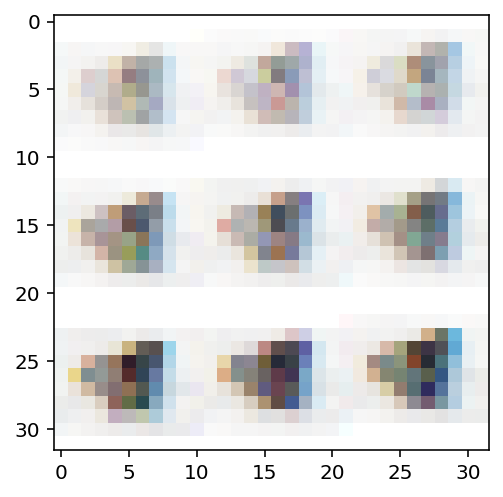

In [142]:
plt.imshow(dataset[0][0].reshape((32,32,3)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


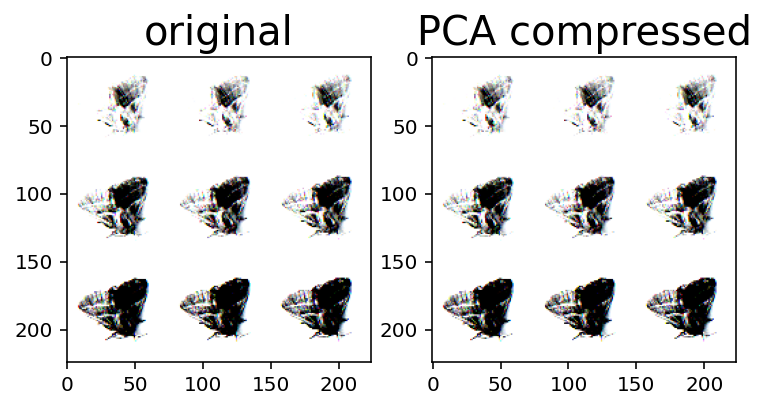

In [67]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_flat[0].reshape((224,224,3)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_reduced[0].reshape((120,120,3 )))
# plt.show(block=True)